In [34]:
using NetCDF, CmdStan, PyPlot, Statistics, PyCall, Interpolations, DataFrames

In [2]:
data_seaflow = Dict("time" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","time",start=[1],count=[-1]),
                    "size_bounds" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","size_bounds",start=[1],count=[-1]),
                    "w_obs" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","w_obs",start=[1,1],count=[-1,-1]),
                    "PAR" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","PAR",start=[1],count=[-1]),
                    "m" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","m")[1],
                    "v_min" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","v_min")[1],
                    "delta_v_inv" => ncread("data/SeaFlow_SizeDist_regrid-15-5.nc","delta_v_inv")[1])

Dict{String,Any} with 7 entries:
  "size_bounds" => [0.0135, 0.0155074, 0.0178134, 0.0204622, 0.0235049, 0.027, …
  "time"        => [0, 3, 6, 9, 12, 15, 18, 21, 24, 27  …  5729, 5732, 5735, 57…
  "w_obs"       => [0.018937 0.0755286 … 0.000536307 0.000130877; 0.0188122 0.0…
  "PAR"         => [1987.91, 2137.93, 1981.03, 1967.0, 2041.37, 2054.12, 2030.1…
  "m"           => 15
  "v_min"       => 0.0135
  "delta_v_inv" => 5

In [3]:
v_min = data_seaflow["v_min"]
delta_v = 1.0/data_seaflow["delta_v_inv"]
v = v_min .* 2 .^(collect(0:1:data_seaflow["m"]-1)*delta_v);

In [4]:
tmpdir=mktempdir()

"/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_l8edXB"

In [53]:
stan_code1 = """data {
    // size variables
    int<lower=0> m;         // number of size classes
    int<lower=0> nt;        // number of timesteps
    int<lower=0> nt_obs;    // number of timesteps with observations
    // model parameters and input
    int<lower=0> dt;        // delta t in minutes
    real<lower=0> E[nt];    // vector of incident radiation values
    real<lower=0> v_min;    // size in smallest size class in um^-3
    int<lower=0> delta_v_inv;   // inverse of delta_v 
    simplex[m] w_ini;       // initial conditions 
    // observations
    real<lower=0,upper=nt*dt>  t_obs[nt_obs]; // the time of each observation
    real<lower=0> obs[m,nt_obs]; // observations
    int<lower=0,upper=1> i_test[nt_obs]; 
}
transformed data {
    int j;
    real<lower=0> delta_v;
    real<lower=0> dt_days;  // dt in units of days
    real<lower=0> v[m];     // vector of (minimum) sizes for each size class
    int<lower=0> t[nt];     // vector of times in minutes since start 
    int<lower=1, upper=nt> it_obs[nt_obs]; // the time index of each observation
        int<lower=0> n_test;
        n_test = sum(i_test);

    j = 1 + delta_v_inv; 
    delta_v = 1.0/delta_v_inv;
    dt_days = dt/1440.0;
    for (i in 1:m){
        v[i] = v_min*2^((i-1)*delta_v);
    }
    // populate time vector
    t[1] = 0;
    for (i in 2:nt){
        t[i] = (t[i-1] + dt);
    }
    // populate index vector it_obs
    for (k in 1:nt_obs){
        for (i in 1:nt){
            if (t_obs[k]>=t[i] && t_obs[k]<t[i]+dt){
                it_obs[k] = i;
                break;
            }
        }
    }
}
parameters {
    real<lower=0> delta_mu; 
    real<lower=0> delta_sigma; 
    real<lower=0> delta_max[m-j+1,4]; 
    real<lower=0> gamma_max;
    real<lower=0, upper=5000> E_star; 
    real<lower=1e-10> sigma; 
}
transformed parameters {
    matrix[m,nt_obs] mod_obspos;
    {
        // helper variables
        vector[m] w_curr; 
        vector[m] w_next;
        real delta_i = 0.0;
        real gamma;
        real a;
        real tmp;
        int ito = 1;
        int ith = 1;
        
        w_curr = w_ini;

        for (it in 1:nt){ // time-stepping loop
            // record current solution 
            if (it == it_obs[ito]){
                mod_obspos[,ito] = w_curr;
                ito += 1;
                if (ito > nt_obs){
                    break;
                }
            }
            // compute gamma
            gamma = gamma_max * dt_days * (1.0 - exp(-E[it]/E_star));
            w_next = rep_vector(0.0, m);
            for (i in 1:m){ // size-class loop
                // compute delta_i
                if (i >= j){
                    delta_i = delta_max[i-j+1,ith] * dt_days;
                }
                
                // fill subdiagonal (growth)
                if (i < j){
                    //A[i+1,i] = gamma;
                    a = gamma;
                    w_next[i+1] += a * w_curr[i];
                } else if (i < m){
                    //A[i+1,i] = gamma * (1.0-delta_i);
                    a = gamma * (1.0-delta_i);
                    w_next[i+1] += a * w_curr[i];
                }
                // fill (j-1)th superdiagonal (division)
                if (i >= j){
                    //A[i+1-j,i] = 2.0*delta_i;
                    a = 2.0*delta_i;
                    w_next[i+1-j] += a * w_curr[i];
                }
                // fill diagonal (stasis)
                if (i < j){
                    //A[i,i] = (1.0-gamma);
                    a = (1.0-gamma);
                    w_next[i] += a * w_curr[i];
                } else if (i == m){
                    //A[i,i] = (1.0-delta_i);
                    a = (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                } else {
                    //A[i,i] = (1.0-gamma) * (1.0-delta_i);
                    a = (1.0-gamma) * (1.0-delta_i);
                    w_next[i] += a * w_curr[i];
                }
            }
            w_curr = w_next ./ sum(w_next);
            ith = 1;
            while(ith*360<t[it]%1440){
                ith += 1;
            }
        }
    }
}
model {
    real diff;
    
    // priors
    delta_mu ~ normal(66.0, 1.0);
    delta_sigma ~ normal(5.0, 1.0);
    for (im in 1:4){
        delta_max[,im] ~ normal(delta_mu, delta_sigma); // T[0.0,1440.0/dt];
    }
    gamma_max ~ uniform(0.0,1440.0/dt);
    E_star ~ normal(3000.0,10.0);
    sigma ~ exponential(1000.0);

    // fitting observations
    for (it in 1:nt_obs){
        diff = 0.0;
        for (iv in 1:m){
            diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
        }
        diff = diff/sigma;
        diff ~ normal(0.0, 1.0) T[0,];
    }
}
generated quantities{
    real log_like_test = 0; 
    {real diff;
    for(it in 1:nt_obs){
        if(i_test[it] == 1){
        diff = 0.0;
        for(iv in 1:m){
                diff += fabs(mod_obspos[iv,it] - obs[iv,it]);
            }
            diff = diff/sigma;
            log_like_test += normal_lpdf(diff | 0.0, 1.0);
        }
    }
    log_like_test = log_like_test/n_test;
    }
}
""";

In [54]:
### prepare data for stan model
dt = 20 # in units of minutes
data = Dict("dt" => dt,
            "m" => data_seaflow["m"],
            "v_min" => data_seaflow["v_min"],
            "delta_v_inv" => data_seaflow["delta_v_inv"],
            "obs" => data_seaflow["w_obs"],
            "t_obs" => data_seaflow["time"],
            "E" => data_seaflow["PAR"],
            "w_ini" => data_seaflow["w_obs"][1,:], # use first measurements as initial conditions
            "nt" => 2*1440÷dt,
            "nt_obs" => length(data_seaflow["time"]),
            "i_test" => Int.(vcat(zeros(31),ones(15))))

limit_to_numdays = 2.0
stride_t_obs = 20

itp = interpolate((data["t_obs"],), data["E"], Gridded(Linear()));
data["E"] = itp(collect(1:1:data["nt"])*data["dt"])

ind_obs = findall(x -> x>3, data["t_obs"]);
data["t_obs"] = data["t_obs"][ind_obs];
data["obs"] = data["obs"][ind_obs,:];

if limit_to_numdays > 0
    thresh = limit_to_numdays*1440
    ind_obs = findall(x -> x<thresh, data["t_obs"])
    data["t_obs"] = data["t_obs"][ind_obs]
    data["obs"] = data["obs"][ind_obs,:]
    data["nt"] = Int(thresh÷data["dt"])
end

if stride_t_obs > 0
    data["t_obs"] = data["t_obs"][collect(1:stride_t_obs:length(data["t_obs"]))]
    data["obs"] = data["obs"][collect(1:stride_t_obs:size(data["obs"],1)),:];
end
data["nt_obs"] = size(data["t_obs"],1)
data["obs"] = reverse(rotl90(data["obs"]),dims=1);

In [55]:
stanmodel = Stanmodel(Sample(save_warmup=true, num_warmup=1000, num_samples=2000, thin=1), 
    name="MatrixModel", model=stan_code1, printsummary=false, tmpdir=tmpdir);


File /var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_l8edXB/MatrixModel.stan will be updated.



In [56]:
rc, chn, cnames = stan(stanmodel, data, diagnostics=false,);

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_l8edXB/MatrixModel.stan', line 135, column 8 to column 55)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/var/folders/pb/sxn625r94w77bfkfp_frz08r0000gn/T/jl_l8edXB/MatrixModel.stan', line 135, column 8 to column 55)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs o

In [57]:
chn

Object of type Chains, with data of type 3000×743×4 Array{Float64,3}

Iterations        = 1:3000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 3000
internals         = accept_stat__, divergent__, energy__, lp__, n_leapfrog__, stepsize__, treedepth__
parameters        = E_star, delta_max.1.1, delta_max.1.2, delta_max.1.3, delta_max.1.4, delta_max.2.1, delta_max.2.2, delta_max.2.3, delta_max.2.4, delta_max.3.1, delta_max.3.2, delta_max.3.3, delta_max.3.4, delta_max.4.1, delta_max.4.2, delta_max.4.3, delta_max.4.4, delta_max.5.1, delta_max.5.2, delta_max.5.3, delta_max.5.4, delta_max.6.1, delta_max.6.2, delta_max.6.3, delta_max.6.4, delta_max.7.1, delta_max.7.2, delta_max.7.3, delta_max.7.4, delta_max.8.1, delta_max.8.2, delta_max.8.3, delta_max.8.4, delta_max.9.1, delta_max.9.2, delta_max.9.3, delta_max.9.4, delta_max.10.1, delta_max.10.2, delta_max.10.3, delta_max.10.4, delta_mu, delta_sigma, gamma_max, log_like_test, mod_obspos.1.1, mod_obspos.1.2, mod_obspos

In [58]:
rawdata = DataFrame(chn, showall=true, sorted=true, append_chains=true);

In [65]:
deltas = Matrix(rawdata[:,2:41])
#rawdata[:,2:461]
deltas = reshape(deltas,12000,4,10);

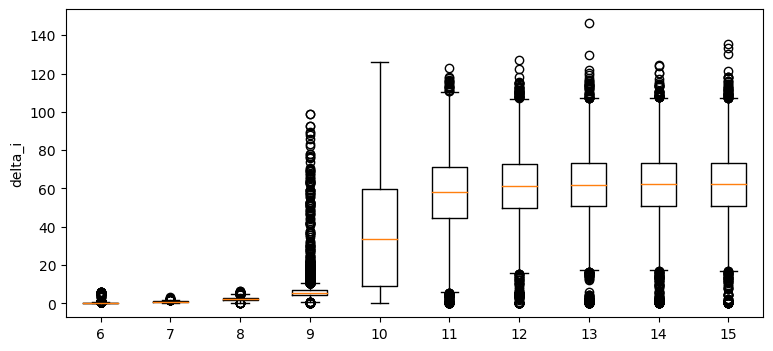

In [66]:
fig, ax = PyPlot.subplots(figsize=(9,4))
ax.boxplot(deltas[:,2,:], positions=collect(6:1:15))
ax.set(ylabel="delta_i");
#ax.yaxis.grid(true)

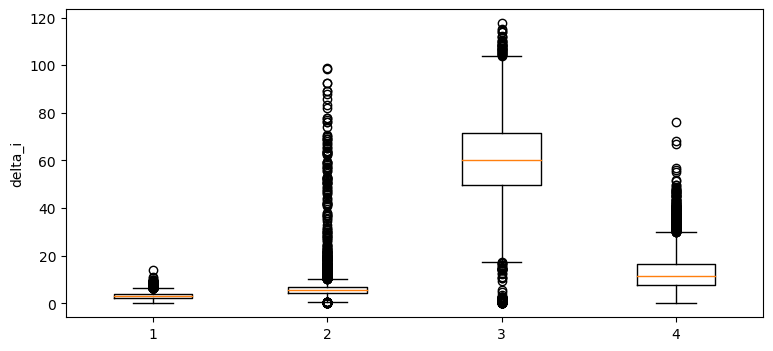

In [71]:
fig, ax = PyPlot.subplots(figsize=(9,4))
ax.boxplot(deltas[:,:,4], positions=collect(1:1:4))
ax.set(ylabel="delta_i");
#ax.yaxis.grid(true)

In [73]:
deltas_m = reshape(chn.info[1].x[2][1][3:42,2],10,4)

10×4 Array{Float64,2}:
  0.229354   5.07513  57.3088  62.0572
  1.17987    3.13278  62.1004  62.1045
  2.81091    6.17203  55.975   62.1156
  1.57053   60.4252   42.6707  61.8218
  0.780061  12.8471   61.2412  61.929 
  3.97479    4.14566  61.8662  62.047 
  5.1       36.2921   61.5797  61.9739
  1.53088   61.667    59.7422  61.8326
  2.39555   31.8407   61.9161  61.9706
 41.1839     6.54948  61.6915  62.082 

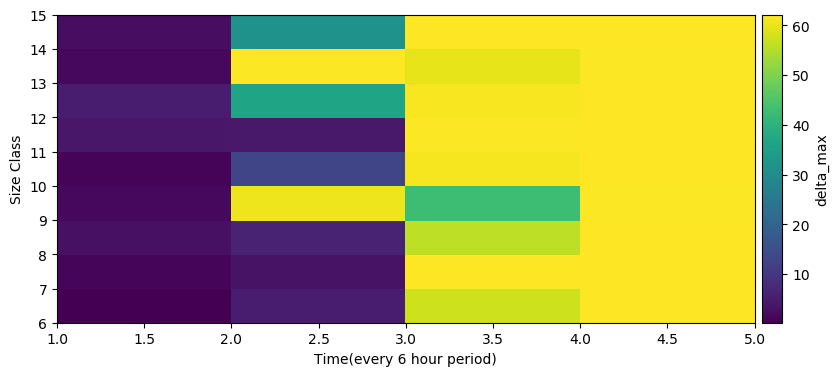

In [78]:
inset_locator = pyimport("mpl_toolkits.axes_grid1.inset_locator")
fig, ax = PyPlot.subplots(figsize=(9,4))
p1 = ax.pcolormesh(collect(1:1:5),collect(6:1:15),deltas_m);
p1b = inset_locator.inset_axes(ax, width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
fig.colorbar(p1,cax=p1b, pad = 0.02,label="delta_max");
ax.set(ylabel="Size Class")
ax.set(xlabel="Time(every 6 hour period)");

In [92]:
res = Dict("model" => reverse(rotl90(reshape(chn.info[1].x[2][1][46:735,2],46,15)),dims=1), "obs" => data["obs"])
diff = res["model"]-res["obs"];
t = collect(1:1:data["nt"])*data["dt"];

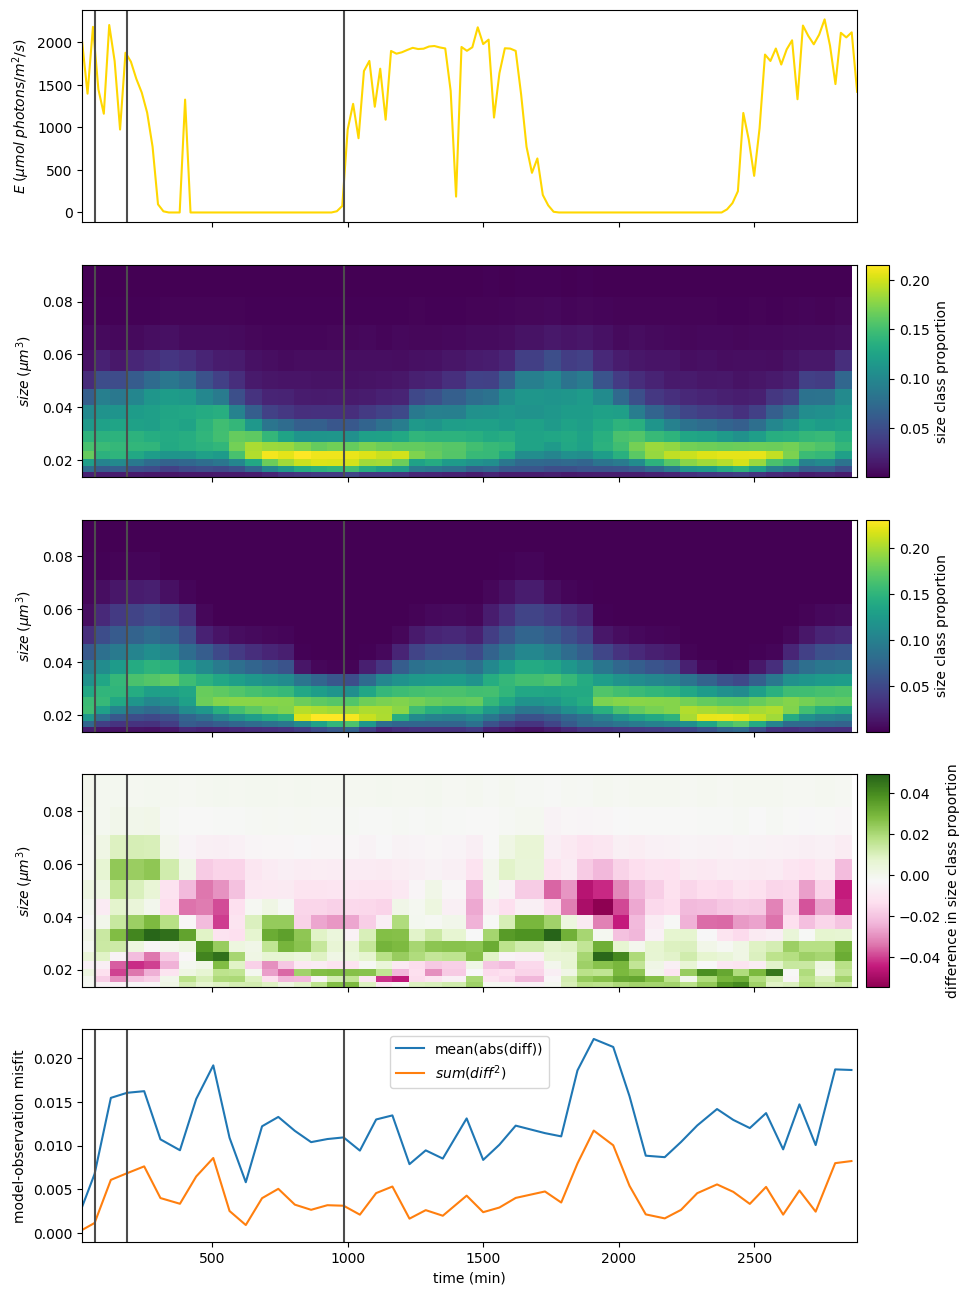

In [94]:
cm = pyimport("matplotlib.cm")
fig,axs = plt.subplots(5,1,sharex=true,figsize=(10,16))
axs[1].plot(t, data["E"], color="gold")
axs[1].set(xlim=(t[1],t[end]), ylabel=L"E\;(\mu mol\;photons/m^{2}/s)")

p2 = axs[2].pcolormesh(data["t_obs"],v,res["obs"])
axs[2].set(ylabel=L"size\;(\mu m^3)")
p2b = inset_locator.inset_axes(axs[2], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[2].transAxes)
fig.colorbar(p2,cax=p2b, pad = 0.02,label="size class proportion");

axs[3].set(ylabel=L"size\;(\mu m^3)")
p3 = axs[3].pcolormesh(data["t_obs"],v,res["model"])
p3b = inset_locator.inset_axes(axs[3], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[3].transAxes)
fig.colorbar(p3,cax=p3b, pad = 0.02,label="size class proportion");

p4 = axs[4].pcolormesh(data["t_obs"],v,diff,cmap=cm.PiYG)
axs[4].set(ylabel=L"size\;(\mu m^3)")
p4b = inset_locator.inset_axes(axs[4], width="3%", height="100%", loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=axs[4].transAxes)
fig.colorbar(p4,cax=p4b, pad = 0.02,label="difference in size class proportion");

prop = mean(abs.(diff),dims=1)[1,:]
axs[5].plot(data["t_obs"], prop, label="mean(abs(diff))")
prop = sum(diff.^2,dims=1)[1,:]
axs[5].plot(data["t_obs"], prop, label=L"sum(diff^2)")
axs[5].set(xlabel="time (min)", ylabel="model-observation misfit")
axs[5].legend();

slice_indices = [1,3,16].+1
for ax in axs
    for i in slice_indices
        ax.axvline(data["t_obs"][i], color=".3")
    end
end

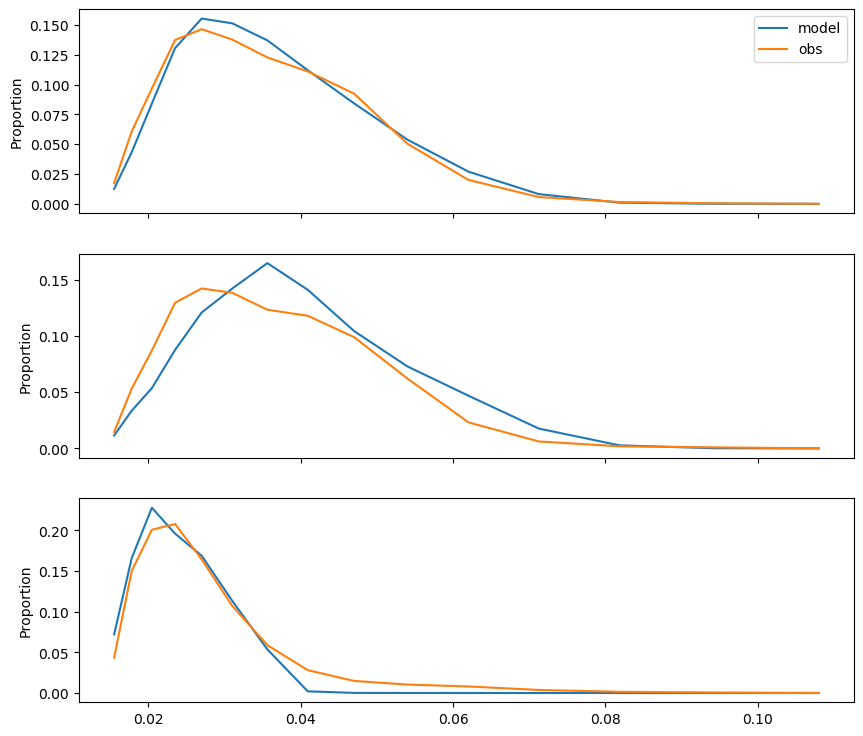

In [96]:
v_ext = data["v_min"] .* 2 .^(collect(1:1:data["m"]) .*delta_v) 
v_width = v_ext[2:end] .- v_ext[1:end-1]
fig,axs = plt.subplots(nrows=length(slice_indices), sharex=true, figsize=(10,length(slice_indices)*3))
for i in 1:length(slice_indices)
    axs[i].plot(v_ext,res["model"][:,slice_indices[i]],label = "model")
    axs[i].plot(v_ext,res["obs"][:,slice_indices[i]],label = "obs")
    axs[i].set_ylabel("Proportion")
end
axs[1].legend();